## 8. Attention

- Attention은 시계열 데이터를 다른 시계열 데이터로 변환하고자 할 때
- 출발 시계열 데이터의 특정 부분이 도착 시계열 데이터의 **특정 부분을 바라보도록 주목**하게 만드는 알고리즘
- 즉 기존의 seq2seq, LSTM처럼 이전의 모든 정보를 보기보다는 특정한 정보만을 보도록 하기
- 이러한 Attention 매커니즘을 이용하여 seq2seq의 구조적인 개선을 취해보기
- Attention에 관한 자세한 설명을 담은 사이트 참조: https://blog.naver.com/PostView.nhn?blogId=ckdgus1433&logNo=221608376139&parentCategoryNo=&categoryNo=12&viewDate=&isShowPopularPosts=true&from=search

### 1) Encoder 개선
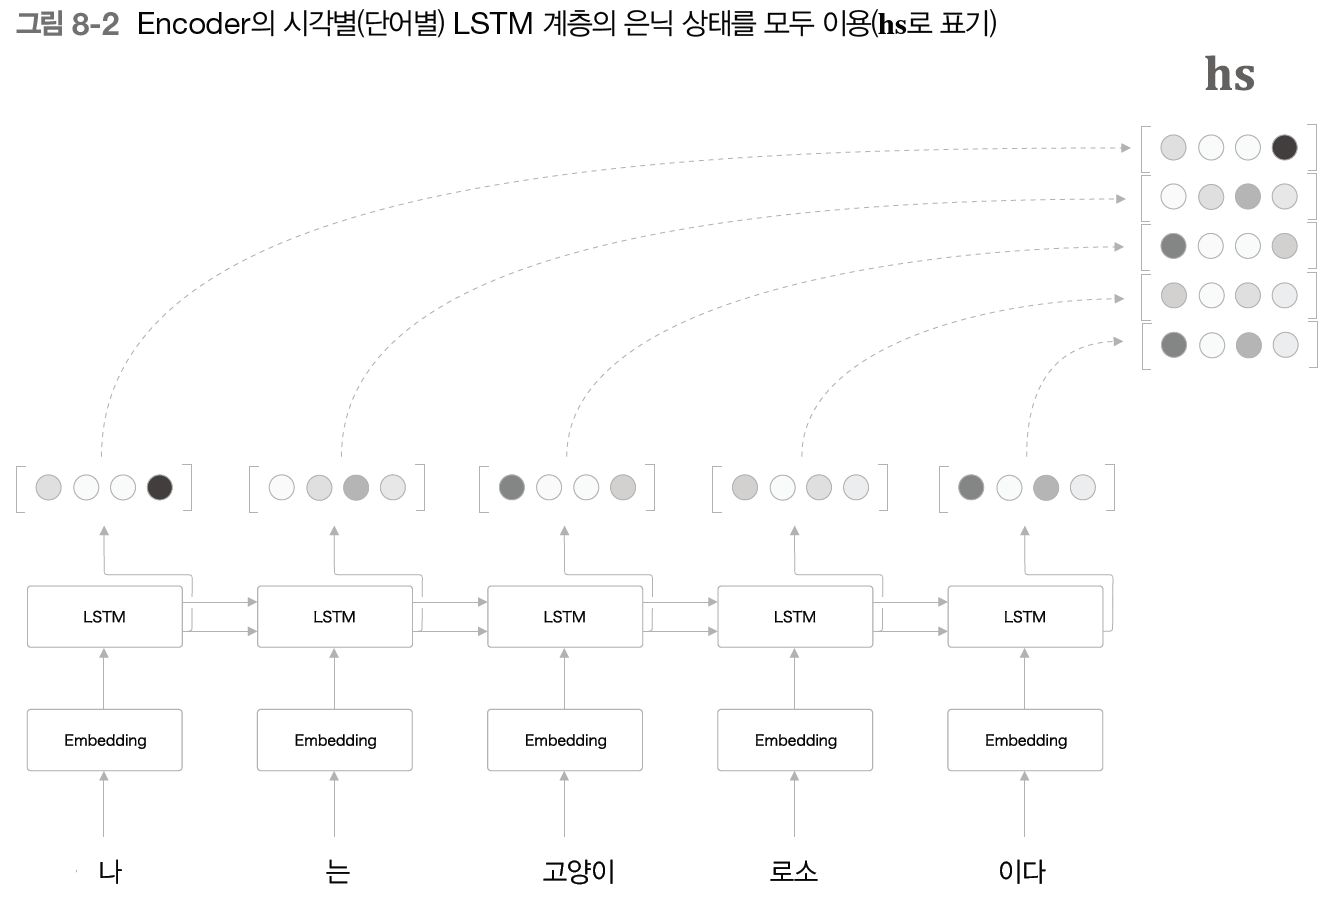
- 기존: 최종 layer의 h만을 Decoder로 보냄. 유일한 정보이나 input의 시계열 정보가 많아질수록 고정길이 h 벡터가 input의 충분한 정보를 담지 못함
- 개선: Encoder의 각 layer가 생성한 은닉벡터들을 vstack 하여서 hs라는 벡터를 생성, 이를 Decoder층에 전달
    - input의 시계열 정보 길이에 따라서 hs의 크기가 달라지므로 hs는 이전의 h와 달리 **가변길이 벡터**임
    
### 2) Decoder 개선1 - Attention Weights & Attention Output
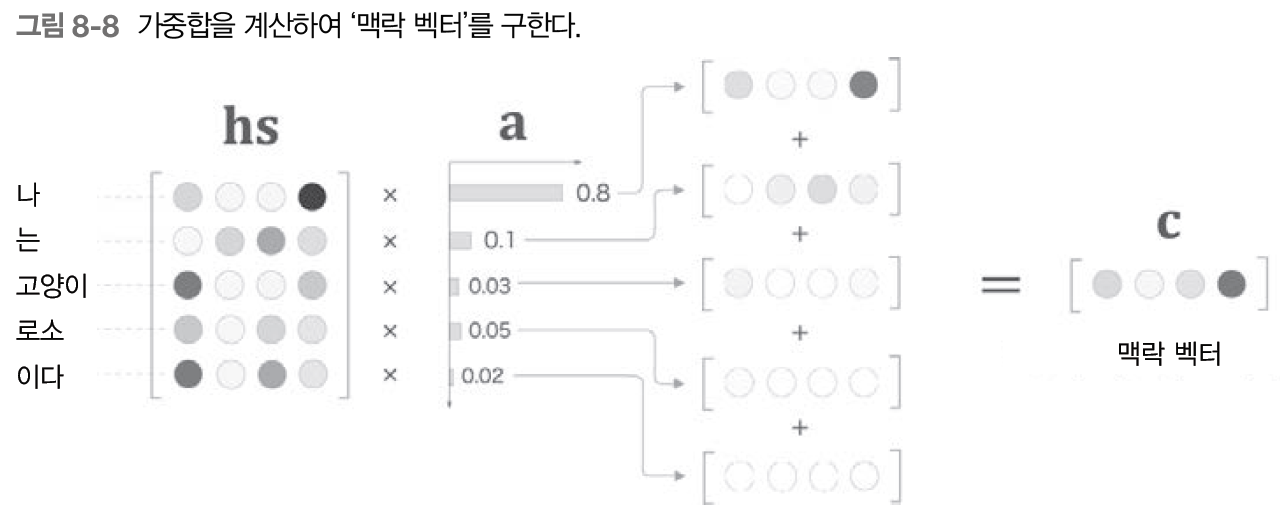
- 기존: Encoder에서  받은 h와 정답 input을 LSTM계층에 투입하여 학습한뒤 Affine -> Softmax 계층을 거쳐서 학습 진행
- 개선: hs의 각 시계열 단계에 맞는 h만을 **선택하는 효과를 발휘하는 알고리즘**을 이용하여 가중합 맥락벡터 c를 생성 -> **Attention Weights**를 이용하여 **Attention Output**을 생ㅅ헝
- Attention Output는 hs에 가중치 벡터 a를 곱하고 이를 가중합하여 생성

In [1]:
#Attention Score 계산 예제
import numpy as np

T, H = 5, 4 #시계열 길이는 5, 은닉벡터 차원은 4
hs = np.random.randn(T, H)
a = np.array([0.8, 0.1, 0.03, 0.05, 0.02])

ar = a.reshape(5, 1).repeat(4, axis = 1)
print(ar.shape)

t = hs * ar
print(t.shape)

c = np.sum(t, axis = 0)
print(c.shape)

(5, 4)
(5, 4)
(4,)


In [2]:
ar #가중치 행렬을 repeat 하여 생성

array([[0.8 , 0.8 , 0.8 , 0.8 ],
       [0.1 , 0.1 , 0.1 , 0.1 ],
       [0.03, 0.03, 0.03, 0.03],
       [0.05, 0.05, 0.05, 0.05],
       [0.02, 0.02, 0.02, 0.02]])

In [3]:
t #은닉행렬 * 가중치 행렬

array([[-1.07516054,  0.43821277,  0.66492369,  0.32492816],
       [ 0.01169313, -0.07614809,  0.03159485, -0.0473968 ],
       [ 0.02065029,  0.01095723, -0.00925664, -0.00440774],
       [ 0.06099135,  0.00363466, -0.03880195,  0.02199382],
       [-0.01166075, -0.02355589,  0.00449025, -0.00723143]])

In [4]:
c #t의 열 방향 합산

array([-0.99348651,  0.35310068,  0.65295019,  0.28788601])

In [5]:
#미니 배치 방식의 Attention Score 계산 과정

N, T, H = 10, 5, 4 #N은 배치 사이즈
hs = np.random.randn(N, T, H)
a = np.random.randn(N, T)
ar = a.reshape(N, T, 1).repeat(H, axis = 2)
#전체적으로 바뀐부분은 N을 추가한 것과 axis가 1씩 밀린 것 밖에 없으므로 겁먹을 필요 없다

t = hs * ar
print(t.shape)

c = np.sum(t, axis = 1) 
#sum의 axis지정을 한 층의 축은 사라지게 된다. 
#우리는 은닉벡터 차원에 집중해야 하므로 시계열 길이에 해당하는 축을 삭제하면 된다
print(c.shape)

(10, 5, 4)
(10, 4)


In [6]:
hs

array([[[ 0.76307961, -1.63735028, -0.62085115,  0.83371394],
        [ 0.8713699 , -0.44564421, -1.28596259,  1.59195802],
        [-0.1849968 , -1.33960491,  0.37166168,  1.27700248],
        [-0.46171832,  0.32824894, -0.63578021,  1.21302242],
        [ 1.13514277, -0.15655249,  1.19101286, -0.61009374]],

       [[ 2.56007106,  1.61983642,  0.80330055, -0.25568078],
        [-0.17656731, -0.56262141, -0.01247098, -0.77237736],
        [-1.3521765 ,  0.55633816,  1.90852972,  0.3138485 ],
        [ 0.19329503, -0.13426846, -0.86241283,  0.55993171],
        [-1.23580973,  0.65159507, -0.34349034, -0.26332589]],

       [[ 1.91642284, -0.69908091,  0.60392606,  1.28539243],
        [-0.14957596, -0.3955909 ,  0.41404881,  0.21841996],
        [-0.22303602,  0.72271944, -0.49002022,  0.60663318],
        [-1.09144682,  1.26029414, -0.12831188,  2.11082252],
        [ 1.42792907, -0.24094157,  1.44399658,  1.3111155 ]],

       [[ 0.78056564,  0.75163161, -0.04359066,  0.07211561],
  

In [7]:
a

array([[-0.26642222,  0.80481249,  0.42714565, -0.51551285,  0.05739662],
       [ 0.17612561,  1.63063231, -0.47226824,  0.74648633, -0.76034202],
       [-0.03169161,  1.09242283,  0.54679955, -0.33887681, -0.68046671],
       [-0.6242861 ,  1.56262785, -0.77175116, -0.45628435, -0.08904677],
       [-0.06176563,  0.76858734, -0.55193839,  2.00818245,  0.28557454],
       [-0.13637724, -1.75071517, -0.14494867,  0.91238281,  0.8813388 ],
       [-0.64152224, -0.04214524, -1.00186121, -0.40725618, -1.12574141],
       [-0.95399221, -0.21083546, -0.85388039, -0.26355453,  1.04603307],
       [-1.53028245, -0.62702292,  0.70508771,  0.78600214,  0.42823711],
       [-0.88479744,  0.79963882,  1.28104659, -0.09943481,  0.74228757]])

In [8]:
ar.shape

(10, 5, 4)

### 2.1) Attention Weights & Attention Output 계산 그래프 형태로 구현하기
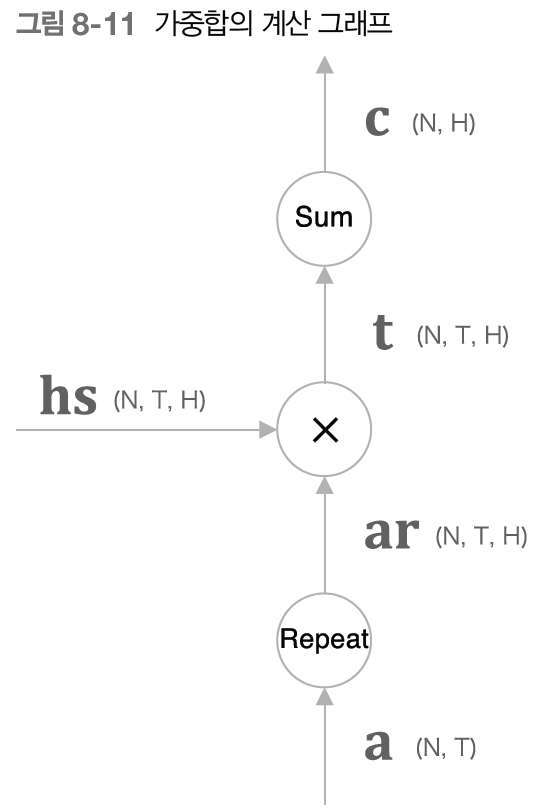
- hs는 Encoder에서 생성된 출발 단어들의 정보를 담은 은닉행렬
- a는 hs에 곱할 가중치를 담은 벡터, Attention Score
- ar는 repeat노드에 의해서 생성
- t는 hs * ar로 생성
- c는 t의 가중합 벡터. 최종 Attention Output

In [9]:
#위의 과정을 구현하기

class WeightSum:
    def __init__(self):
        self.params, self.grads = [], []
        self.cache = None
        
    def forward(self, hs, a):
        N, T, H = hs.shape
        
        ar = a.reshape(N, T, 1).repeat(H, axis = 2)
        t = hs * ar
        c = np.sum(t, axis = 1)
        
        self.cache = (hs, ar)
        return c
    
    def backward(self, dc):
        hs, ar = self.cache
        N, T, H = hs.shape
        
        dt = dc.reshape(N, 1, H).repeat(T, axis = 1) #sum 노드의 역전파 -> Repeat
        dar = dt * hs #곱셈 노드의 역전파 -> 반대편 노드와의 곱셈
        dhs = dt * ar
        da = np.sum(dar, axis =2) #repeat 노드의 역전파 -> Sum
        
        return dhs, da

### 3) Decoder 개선2 - Attention Score & Attention Distribution 구하기
- Attention Weights에 해당하는 a를 구하기 위한 과정을 구현
- Decoder의 LSTM층 Output에 해당하는 h와 Encoder의 hs간의 벡터 내적 연산을 수행하여 s를 구하기 -> **Attention Score**
    - 벡터 내적을 취하는 이유는 h와 hs간의 유사성을 판단하는 점수를 내기 위함
    - 내적은 두 벡터가 얼마나 **같은 방향**을 향하고 있는지를 판단하기 위해 수행
- s는 정규화된 점수가 아니므로 Softmax층을 통과하여 정규화를 시킨 a를 생성 -> **Attention Distribution** 수행 + Attention Weights 생성

In [10]:
#Attention Score를 생성하고 이용하는 과정 예제
import sys
sys.path.append(r'C:\Users\myunghoon_k\OneDrive - UOS\bitamin\dl_nlp_study\deep-learning-from-scratch-2-master')

from common.layers import Softmax

N, T, H = 10, 5, 4
hs = np.random.randn(N, T, H) #Encoder를 통해 생성된 은닉행렬
h = np.random.randn(N, H) #Decoder의 각 LSTM레이어별로 생성된 은닉벡터
hr = h.reshape(N, 1, H).repeat(T, axis = 1)

t = hs * hr
print(t.shape)

s = np.sum(t, axis = 2)

softmax = Softmax()
a = softmax.forward(s)
print(a.shape)

(10, 5, 4)
(10, 5)


### 3.1) Attention Score & Attention Distribution 계산 그래프 형태로 구현하기
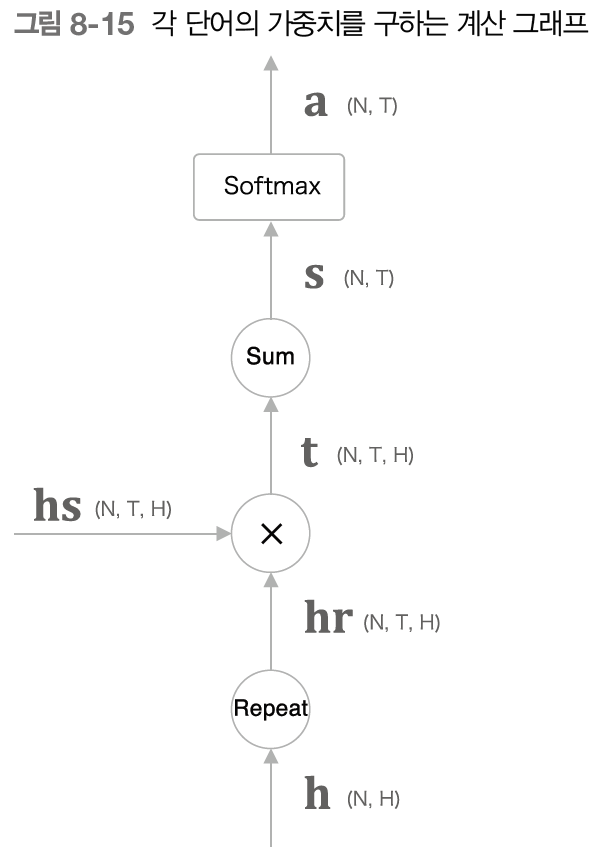

- h는 Decoder LSTM의 은닉 output
- hs는 Encoder의 은닉 output
- t는 hs * hr (hr은 h가 repeat노드를 거쳐서 생성된 tensor)
- s는 t가 Sum노드를 거쳐서 생성된 output
- a는 Softamx노드를 거쳐서 생성된 정규화된 가중치 벡터

In [11]:
#위의 과정을 구현하기
class AttentionWeight:
    def __init__(self):
        self.params, self.grads = [], []
        self.softmax = Softmax()
        self.cache = None
        
    def forward(self, hs, h):
        N, T, H = hs.shape
        
        hr = h.reshape(N, 1, H).repeat(T, axis = 1)
        t = hs * hr
        s = np.sum(t, axis = 2)
        a = self.softmax.forward(s)
        
        self.cache = (hs, hr)
        return a
    
    def backward(self, da):
        hs, hr = self.cache
        N, T, H = hs.shape
        
        ds = self.softmax.backward(da)
        dt = ds.reshape(N, T, 1).repeat(H, axis = 2) #sum 노드의 역전파 -> Repeat
        dhs = dt * hr
        dhr = dt * hs
        dh = np.sum(dhr, axis = 1) #repeat 노드의 역전파 -> Sum
        
        return dhs, dh

### 4) Decoder의 Attention Layer구조
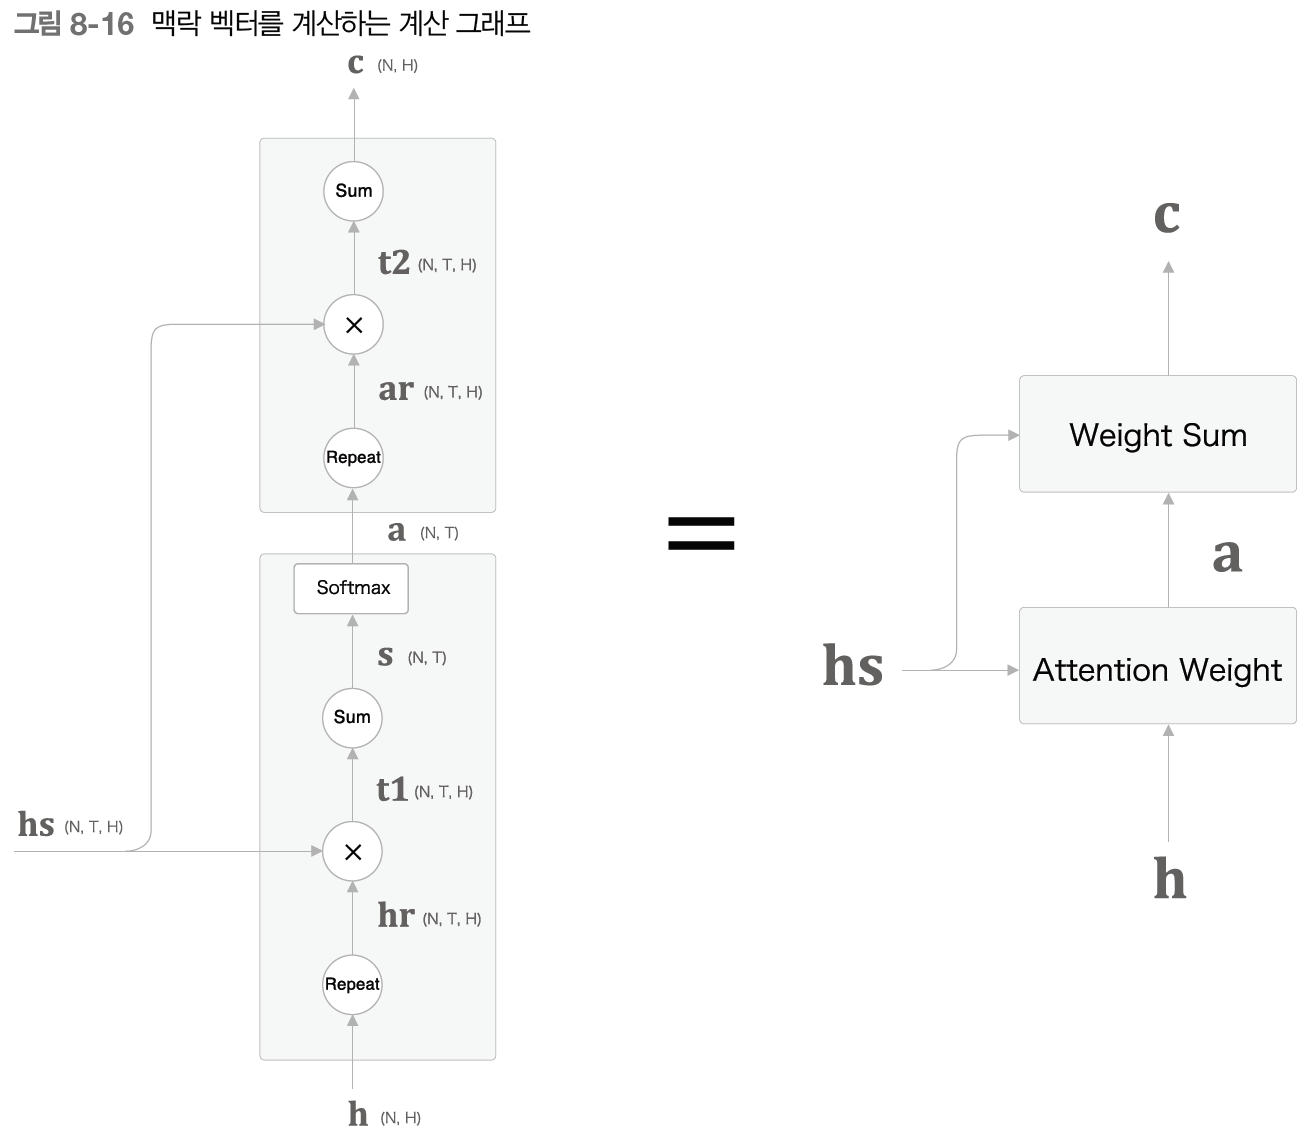

In [12]:
#Attention class를 생성하기
class Attention:
    def __init__(self):
        self.params, self.grads = [], []
        self.attention_weight_layer = AttentionWeight()
        self.weight_sum_layer = WeightSum()
        self.attention_weight = None
        
    def forward(self, hs, h):
        a = self.attention_weight_layer.forward(hs, h)
        out = self.weight_sum_layer.forward(hs, a)
        self.attention_weight = a
        return out
    
    def backward(self, dout):
        dhs0, da = self.weight_sum_layer.backward(dout)
        dhs1, dh = self.weight_sum_layer.backward(da)
        dhs = dhs0 + dhs1 #hs자체가 repeat노드가 repeat형식으로 분기했기 때문에 역전파는 Sum
        return dhs, dh

## Attention 계층이 추가된 seq2seq 구조도
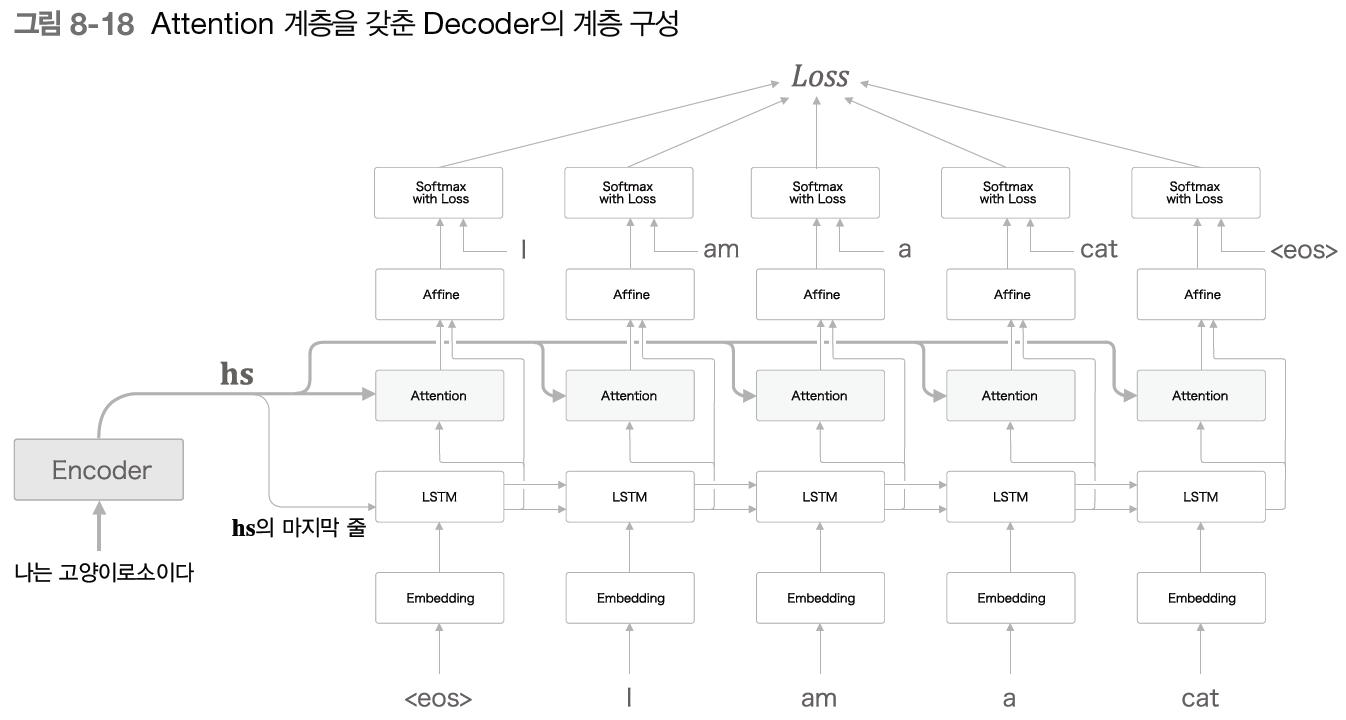

In [13]:
#Time 형식으로 Attention 계층 구현하기
class TimeAttention:
    def __init__(self):
        self.params, self.grads = [], []
        self.layers = None
        self.attention_weights = None
        
    def forward(self, hs_enc, hs_dec):
        N, T, H = hs_dec.shape
        out = np.empty_like(hs_dec)
        self.layers = []
        self.attention_weights = []
        
        for t in range(T):
            layer = Attention()
            out[:, t, :] = layer.forward(hs_enc, hs_dec[:, t, :])
            self.layers.append(layer)
            self.attention_weights.append(layer.attention_weight)
            
        return out
    
    def backward(self, dout):
        N, T, H = hs_dec.shape
        dhs_enc = 0
        dhs_dec = np.empty_like(dout)
        
        for t in range(T):
            layer = self.layers[t]
            dhs, dh = layer.backward(dout[:, t, :])
            dhs_enc += dhs
            dhs_dec[:, t, :] = dh
            
        return dhs_enc, dhs_dec

## Attention개념을 도입한 seq2seq 구현

In [14]:
#Attention Encoder 구현
import sys
sys.path.append(r'C:\Users\myunghoon_k\OneDrive - UOS\bitamin\dl_nlp_study\deep-learning-from-scratch-2-master')
from common.time_layers import *
from ch07.seq2seq import Encoder, Seq2seq

class AttentionEncoder(Encoder): 
    #Encoder 클래스를 상속받아서 init의 인스턴스 객체들을 그대로 쓰겠다는 의미
    def forward(self, xs):
        xs = self.embed.forward(xs)
        hs = self.lstm.forward(xs)
        return hs
    
    def backward(self, dhs):
        dout = self.lstm.backward(dhs)
        dout = self.embed.backward(dout)
        return dout

In [15]:
#Attention Decoder 구현

class AttentionDecoder:
    def __init__(self, vocab_size, wordvec_size, hidden_size):
        V, D, H = vocab_size, wordvec_size, hidden_size
        rn = np.random.randn

        embed_W = (rn(V, D) / 100).astype('f') # x -> embed
        lstm_Wx = (rn(D, 4 * H) / np.sqrt(D)).astype('f') # embed -> LSTM
        lstm_Wh = (rn(H, 4 * H) / np.sqrt(H)).astype('f') # Encoder LSTM -> LSTM
        lstm_b = np.zeros(4 * H).astype('f')
        affine_W = (rn(2*H, V) / np.sqrt(2*H)).astype('f') # Attention -> Affine
        affine_b = np.zeros(V).astype('f')
        
        '''
        LSTM -> Attention 계층사이에 가중치 instacne변수가 추가되지 않는 이유는 다음과 같다
        
        1. LSTM -> Attention 계층이동시에 input 데이터의 형변환이 없다
        즉 LSTM의 은닉 output이 그대로 Attention계층에 투입된다. 
        
        2. H와 C의 형상이 같다
        LSTM의 은닉 output H와 Attention 계층을 통과하여 생성된 C의 형상이 같다
        이는 C가 단순 현 시점의 LSTM계층을 통과하여 생성된 H에 
        이전 시점의 특정한 정보를 가중하기 위해 생성된 output임을 기억하면 형상이 같아야 함이 타당하다
        '''
        
        self.embed = TimeEmbedding(embed_W)
        self.lstm = TimeLSTM(lstm_Wx, lstm_Wh, lstm_b, stateful = True)
        self.attention = TimeAttention()
        self.affine = TimeAffine(affine_W, affine_b)
        layers = [self.embed, self.lstm, self.attention, self.affine]
        
        self.params, self.grads = [], []
        for layer in layers:
            self.params += layer.params
            self.grads += layer.grads
            
    def forward(self, xs, enc_hs):
        h = enc_hs[:, -1]
        self.lstm.set_state(h)
        
        out = self.embed.forward(xs)
        dec_hs = self.lstm.forward(out)
        c = self.attention.forward(enc_hs, dec_hs)
        out = np.concatenate((c, dec_hs), axis = 2) #단순 두 행렬을 붙이는 형태로 Affine 계층에 넘어감
        score = self.affine.forward(out)
        
        return score
    
    def backward(self, dscore):
        dout = self.affine.backward(dscore)
        N, T, H2 = dout.shape
        H = H2 // 2 
        #C와 H는 형상이 같으므로 cocnat된 H2의 차원의 절반은 H의 차원과 동일
        #concat을 함으로써 생성되는 out을 둘로 나눠서 각각 역전파를 해야함
        
        dc, ddec_hs0 = dout[:, :, :H], dout[:, :, H:] #Affine 층 투입전 C와 H의 concat이 이뤄졌으므로 분리하기
        denc_hs, ddec_hs1 = self.attention.backward(dc) #C의 역전파. enc_hs, dec_hs가 사용되었므로 2개의 역전파 output
        ddec_hs = ddec_hs0 + ddec_hs1 #dec_hs가 Attention투입과 Affine 투입 단계에서 2번 repeat되었으므로 Sum
        dout = self.lstm.backward(ddec_hs)
        dh = self.lstm.dh
        denc_hs[:, -1] += dh #Decoder의 :STM 역전파 값을 반영하기
        self.embed.backward(dout)
        
        return denc_hs
    
    def generate(self, enc_hs, start_id, sample_size):
        sampled = []
        sample_id = start_id
        h = enc_hs[:, -1]
        self.lstm.set_state(h)
        
        for _ in range(sample_size):
            x = np.array([sample_id]).reshape((1,1))
            
            #Decoder의 forward과정과 동일
            out = self.embed.forward(x)
            dec_hs = self.lstm.forward(out)
            c = self.attention.forward(enc_hs, dec_hs)
            out = np.concatenate((c, dec_hs), axis=2)
            score = self.affine.forward(out)
            
            sample_id = np.argmax(score.flatten())
            sampled.append(sample_id)
            
        return sampled

In [16]:
#Attention Seq2seq 구현

class AttentionSeq2seq(Seq2seq):
    def __init__(self, vocab_size, wordvec_size, hidden_size):
        args = vocab_size, wordvec_size, hidden_size
        self.encoder = AttentionEncoder(*args)
        self.decoder = AttentionDecoder(*args)
        self.softmax = TimeSoftmaxWithLoss()
        
        self.params = self.encoder.params + self.decoder.params
        self.grads = self.encoder.grads + self.decoder.grads